<h1> Pruebas para Liga de Bolsa </h1>

<h2> Descargar información de las cotizaciones </h2>

Se guardarán la información de la cotización en un dataframe de pequeñas dimensiones y con la mínima información posible para ahorrar memoria.

In [8]:
# Install investpy package. This first command does not work.
# ! pip install git+https://github.com/alvarobartt/investpy.git@master
# This one works!
#! pip install investpy

In [29]:
import investpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics

In [10]:
# Load some historical data from the AAPL stock. Date format is: dd/mm/yyyy
    # Frequency: daily
    # Open, maximum, minimum and close prices, volume and currency.
aapl = investpy.get_stock_historical_data(stock='AAPL', country='United States', from_date='01/01/2020', to_date='30/10/2021')
aapl

# Get the five first values of volume from the df dataframe
# with these example options:
# 1. df.iloc[0:5]["Volume"] 
# 2. df.head()["Volume"]

# The same, but with the last five values:
# 1. df.iloc[-5:]["Volume"]
# 2. df.tail()["Volume"]

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-01-02,74.06,75.15,73.80,75.09,135647008,USD
2020-01-03,74.29,75.14,74.13,74.36,146536000,USD
2020-01-06,73.45,74.99,73.19,74.95,118579000,USD
2020-01-07,74.96,75.22,74.37,74.60,111511000,USD
2020-01-08,74.29,76.11,74.29,75.80,132364000,USD
...,...,...,...,...,...,...
2021-10-25,148.68,149.37,147.62,148.64,50380000,USD
2021-10-26,149.33,150.84,149.01,149.32,60632000,USD
2021-10-27,149.36,149.73,148.49,148.85,55788000,USD


In [11]:
# Load futher data from a stock

# Apple stock will be saved at search_result
aapl_info = investpy.search_quotes(text='apple', products=['stocks'], countries=['united states'], n_results=1)
# Save the information in a dict variable
aapl_info = aapl_info.retrieve_information()
print(aapl_info)

# Technical information:
    # prevClose, dailyRange, open (most recent), weekRange (most recent), volume(unkwown) avgVolume(it could be weekly)
# Fundamental information:
    # revenue, eps (earning per share), marketCap, dividend (last), ratio (P/E).
# Other or both
    # beta, oneYearReturn, sharesOutstanding, nextEarningDate

'''
# avgVolume: 74388303

for x in range(1, len(df["Volume"])):
    print(f"{x}: {df.tail(x)['Volume'].mean()}")
    # mean output 29 is similar

for x in range(1, len(df["Volume"])):
    print(f"{x}: {df.tail(x)['Volume'].median()}")
    # median output 30 is similar
'''


{'prevClose': 152.57, 'dailyRange': '146.41-149.94', 'revenue': 347160000000, 'open': 147.21, 'weekRange': '107.32-157.26', 'eps': 5.61, 'volume': 120511817, 'marketCap': 2460000000000, 'dividend': '0.88(0.58%)', 'avgVolume': 74388303, 'ratio': 26.72, 'beta': 1.21, 'oneYearReturn': '37.62%', 'sharesOutstanding': 16406397000, 'nextEarningDate': '01/02/2022'}


'\n# avgVolume: 74388303\n\nfor x in range(1, len(df["Volume"])):\n    print(f"{x}: {df.tail(x)[\'Volume\'].mean()}")\n    # mean output 29 is similar\n\nfor x in range(1, len(df["Volume"])):\n    print(f"{x}: {df.tail(x)[\'Volume\'].median()}")\n    # median output 30 is similar\n'

In [12]:
# import investpy

# s_results = investpy.search_quotes(text='a', products=['stocks'], countries=['united states'], n_results=10)

# s_results = map(lambda x: print(x), s_results)

## Technical analysis
Futher information [here](https://medium.com/codex/this-python-library-will-help-you-get-stock-technical-indicators-in-one-line-of-code-c11ed2c8e45f) (stockstats) and [here](https://towardsdatascience.com/technical-analysis-library-to-financial-datasets-with-pandas-python-4b2b390d3543) (ta).

In [13]:
# ! pip3 install stockstats
# ! pip3 install ta

In [16]:
# Technical analysis libraries
from stockstats import StockDataFrame
import ta


### stockstats library

In [26]:
# Datafrate to Stockstats dataframe library
aapl_sdf = StockDataFrame(aapl)
aapl_sdf.columns = aapl_sdf.columns.str.lower()
aapl_sdf

,open,high,low,close,volume,currency,close_10_sma,close_20_sma,close_50_sma
Date,,,,,,,,,
2020-01-02,74.06,75.15,73.80,75.09,135647008,USD,75.090,75.0900,75.0900
2020-01-03,74.29,75.14,74.13,74.36,146536000,USD,74.725,74.7250,74.7250
2020-01-06,73.45,74.99,73.19,74.95,118579000,USD,74.800,74.8000,74.8000
2020-01-07,74.96,75.22,74.37,74.60,111511000,USD,74.750,74.7500,74.7500
2020-01-08,74.29,76.11,74.29,75.80,132364000,USD,74.960,74.9600,74.9600
...,...,...,...,...,...,...,...,...,...
2021-10-25,148.68,149.37,147.62,148.64,50380000,USD,146.240,144.1270,147.2414
2021-10-26,149.33,150.84,149.01,149.32,60632000,USD,147.021,144.4975,147.2054
2021-10-27,149.36,149.73,148.49,148.85,55788000,USD,147.815,144.7985,147.1786


In [27]:
# Mostrar tres medias móviles (de 10, 20 y 50 periodos), RSI (14 periodos) and MACD
aapl_sdf[['close_10_sma', 'close_20_sma', 'close_50_sma', 'rsi_14', 'macd']]


,close_10_sma,close_20_sma,close_50_sma,rsi_14,macd
Date,,,,,
2020-01-02,75.090,75.0900,75.0900,NaN,0.000000
2020-01-03,74.725,74.7250,74.7250,0.000000,-0.016378
2020-01-06,74.800,74.8000,74.8000,46.535211,-0.002573
2020-01-07,74.750,74.7500,74.7500,35.871054,-0.008868
2020-01-08,74.960,74.9600,74.9600,65.263246,0.035649
...,...,...,...,...,...
2021-10-25,146.240,144.1270,147.2414,58.680918,0.721314
2021-10-26,147.021,144.4975,147.2054,60.388237,0.882859
2021-10-27,147.815,144.7985,147.1786,58.586324,0.961871


OSError: 'dark' not found in the style library and input is not a valid URL or path; see `style.available` for list of available styles

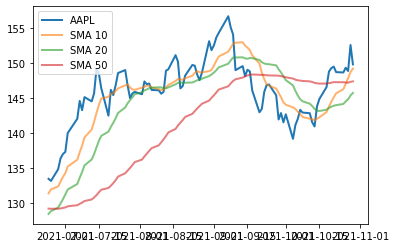

In [40]:
# Plotear las tres medias móviles junto a la cotización
plt.plot(aapl.iloc[-90:]['close'], linewidth = 2, label = 'AAPL')
plt.plot(aapl.iloc[-90:]['close_10_sma'], linewidth = 2, alpha = 0.6, label = 'SMA 10')
plt.plot(aapl.iloc[-90:]['close_20_sma'], linewidth = 2, alpha = 0.6, label = 'SMA 20')
plt.plot(aapl.iloc[-90:]['close_50_sma'], linewidth = 2, alpha = 0.6, label = 'SMA 50')
plt.legend(loc = 'upper left')
plt.show()

### ta library